In [2]:
%reset

# Football Predict
## Questions before start:
We have a bunch of csv files, where each one is divided into categories:
1. Country (belgium, england, france, germany, greece, italy, netherlands, portugal, scotland, spain, turkey)
2. League (0, 1, 2, 3)
3. Season (2000-2001, 2001-2002, ..., 2021-2022)

Should we merge all the csv files into one big dataframe? Or should we keep them separate? 
If we merge them, how do we keep track of the different leagues and seasons?  

## Thoughts:
We could merge them into one big dataframe, and provide analysis on the whole dataset. 
In case we need analyse a specific league or season, we can filter the dataframe accordingly.

**Before merging**, we should add a column for the league and season.


In [3]:
# TODO: 
#  1. try to find in what city match occurred (add as feature), and find related weather data for that city and day (as feature)
#  (DONE) 2. check if particular bookmaker appears only in one (or more) country 
#  (DONE) 3. check if particular bookmaker appears only in one (or more) league
#  (DONE) 4. add weekend/weekday as feature (as "Betting odds for weekend games are collected Friday afternoons, and on Tuesday afternoons for midweek games.")
#  5. add "number of days since last match" as feature
#  6. check correlations in odds across bookmakers, so that we can drop some columns (probably keep only one bookmaker)
#  7. Aggregated columns for bookmakers odds, (min, max, median, mean odd from bookmakers, make column with Interwetten + other so i donn't have missing values).
#  8. convert categorical variables into a format that can be provided to ML algorithms.




In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [5]:
# csv_files = sorted(glob(f'data/train/**/*.csv', recursive=True))

def read_data(folder_path, mac=False):
    df = pd.DataFrame()
    separator = '/' if mac else '\\'

    for file_path in sorted(glob(f'{folder_path}{separator}**{separator}*.csv', recursive=True)):
        csv_file_df = pd.read_csv(file_path)

        # Rename HT and AT columns to HomeTeam and AwayTeam
        if 'HT' in csv_file_df.columns or 'AT' in csv_file_df.columns:
            csv_file_df.rename(columns={'HT': 'HomeTeam', 'AT': 'AwayTeam'}, inplace=True)

        # Extract country, league, and season from file path
        parts = file_path.split(separator)
        country = parts[-3]
        league = parts[-2]
        season = parts[-1].split('.')[0]

        # Add country, league, and season as features to the front
        csv_file_df.insert(0, 'Country', country)
        csv_file_df.insert(1, 'League', league)
        csv_file_df.insert(2, 'Season', season)

        # Convert date to datetime format and sort by date
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%y', errors='ignore')
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%Y', errors='coerce')
        csv_file_df = csv_file_df.sort_values(by='Date')

        # Determine if the game is on a weekend or weekday
        # Weekends are typically Saturday (5) and Sunday (6)
        csv_file_df['DayOfWeek'] = csv_file_df['Date'].dt.dayofweek
        csv_file_df['Weekend'] = csv_file_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        df = pd.concat([df, csv_file_df], ignore_index=True, axis=0, join='outer', sort=False)

    return df

In [6]:
# Read all training data
train_df = read_data('data/train', mac=True)

In [7]:
# Display unique column names and their count
unique_columns = train_df.columns.unique()
column_count = len(unique_columns)

print("Unique Column Names:")
print(unique_columns)

print("\nNumber of Unique Columns:", column_count)

Unique Column Names:
Index(['Country', 'League', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam',
       'FTHG', 'FTAG', 'FTR',
       ...
       'Unnamed: 72', 'LB', 'LB.1', 'LB.2', 'Unnamed: 24', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 53', 'Unnamed: 106'],
      dtype='object', length=215)

Number of Unique Columns: 215


In [8]:
# Drop empty columns starting with "Unnamed"
train_df = train_df.filter(regex='^(?!Unnamed).*$')


In [9]:
# Split columns into categories about match (results data), Match Statistics, and betting odds (as in notes.txt)
# Rename columns later
match_data = {
    "DayOfWeek": "DayOfWeek",
    "Weekend": "Weekend",
    "League": "League",
    "Season": "Season",
    "Country": "Country",
    "Div": "League_Division",
    "Date": "Match_Date",
    "Time": "Time_of_match_kick_off",
    "HomeTeam": "Home_Team",
    "AwayTeam": "Away_Team",
    "FTHG": "Full_Time_Home_Team_Goals",
    "FTAG": "Full_Time_Away_Team_Goals",
    "FTR": "Full_Time_Result",
    "HTHG": "Half_Time_Home_Team_Goals",
    "HTAG": "Half_Time_Away_Team_Goals",
    "HTR": "Half_Time_Result"
}

match_statistics = {
    "Attendance": "Crowd_Attendance",
    "Referee": "Match_Referee",
    "HS": "Home_Team_Shots",
    "AS": "Away_Team_Shots",
    "HST": "Home_Team_Shots_on_Target",
    "AST": "Away_Team_Shots_on_Target",
    "HHW": "Home_Team_Hit_Woodwork",
    "AHW": "Away_Team_Hit_Woodwork",
    "HC": "Home_Team_Corners",
    "AC": "Away_Team_Corners",
    "HF": "Home_Team_Fouls_Committed",
    "AF": "Away_Team_Fouls_Committed",
    "HFKC": "Home_Team_Free_Kicks_Conceded",
    "AFKC": "Away_Team_Free_Kicks_Conceded",
    "HO": "Home_Team_Offsides",
    "AO": "Away_Team_Offsides",
    "HY": "Home_Team_Yellow_Cards",
    "AY": "Away_Team_Yellow_Cards",
    "HR": "Home_Team_Red_Cards",
    "AR": "Away_Team_Red_Cards",
    "HBP": "Home_Team_Bookings_Points",
    "ABP": "Away_Team_Bookings_Points"
}

betting_odds_1x2_match = {
    "B365H": "Bet365_home_win_odds",
    "B365D": "Bet365_draw_odds",
    "B365A": "Bet365_away_win_odds",
    "BSH": "Blue_Square_home_win_odds",
    "BSD": "Blue_Square_draw_odds",
    "BSA": "Blue_Square_away_win_odds",
    "BWH": "Bet&Win_home_win_odds",
    "BWD": "Bet&Win_draw_odds",
    "BWA": "Bet&Win_away_win_odds",
    "GBH": "Gamebookers_home_win_odds",
    "GBD": "Gamebookers_draw_odds",
    "GBA": "Gamebookers_away_win_odds",
    "IWH": "Interwetten_home_win_odds",
    "IWD": "Interwetten_draw_odds",
    "IWA": "Interwetten_away_win_odds",
    "LBH": "Ladbrokes_home_win_odds",
    "LBD": "Ladbrokes_draw_odds",
    "LBA": "Ladbrokes_away_win_odds",
    "PSH": "Pinnacle_home_win_odds",
    "PSD": "Pinnacle_draw_odds",
    "PSA": "Pinnacle_away_win_odds",
    "SOH": "Sporting_Odds_home_win_odds",
    "SOD": "Sporting_Odds_draw_odds",
    "SOA": "Sporting_Odds_away_win_odds",
    "SBH": "Sportingbet_home_win_odds",
    "SBD": "Sportingbet_draw_odds",
    "SBA": "Sportingbet_away_win_odds",
    "SJH": "Stan_James_home_win_odds",
    "SJD": "Stan_James_draw_odds",
    "SJA": "Stan_James_away_win_odds",
    "SYH": "Stanleybet_home_win_odds",
    "SYD": "Stanleybet_draw_odds",
    "SYA": "Stanleybet_away_win_odds",
    "VCH": "VC_Bet_home_win_odds",
    "VCD": "VC_Bet_draw_odds",
    "VCA": "VC_Bet_away_win_odds",
    "WHH": "William_Hill_home_win_odds",
    "WHD": "William_Hill_draw_odds",
    "WHA": "William_Hill_away_win_odds",
    "Bb1X2": "Number_of_BetBrain_bookmakers_used",
    "BbMxH": "Betbrain_maximum_home_win_odds",
    "BbAvH": "Betbrain_average_home_win_odds",
    "BbMxD": "Betbrain_maximum_draw_odds",
    "BbAvD": "Betbrain_average_draw_win_odds",
    "BbMxA": "Betbrain_maximum_away_win_odds",
    "BbAvA": "Betbrain_average_away_win_odds",
    "MaxH": "Market_maximum_home_win_odds",
    "MaxD": "Market_maximum_draw_win_odds",
    "MaxA": "Market_maximum_away_win_odds",
    "AvgH": "Market_average_home_win_odds",
    "AvgD": "Market_average_draw_win_odds",
    "AvgA": "Market_average_away_win_odds",
}

betting_odds_total_goals = {
    "BbOU": "Number_BetBrain_over_under_2.5_goals_averages_and_maximums",
    "BbMx>2.5": "Betbrain_maximum_over_2.5_goals",
    "BbAv>2.5": "Betbrain_average_over_2.5_goals",
    "BbMx<2.5": "Betbrain_maximum_under_2.5_goals",
    "BbAv<2.5": "Betbrain_average_under_2.5_goals",
    "GB>2.5": "Gamebookers_over_2.5_goals",
    "GB<2.5": "Gamebookers_under_2.5_goals",
    "B365>2.5": "Bet365_over_2.5_goals",
    "B365<2.5": "Bet365_under_2.5_goals",
    "P>2.5": "Pinnacle_over_2.5_goals",
    "P<2.5": "Pinnacle_under_2.5_goals",
    "Max>2.5": "Market_maximum_over_2.5_goals",
    "Max<2.5": "Market_maximum_under_2.5_goals",
    "Avg>2.5": "Market_average_over_2.5_goals",
    "Avg<2.5": "Market_average_under_2.5_goals",
}

betting_odds_asian_handicap = {
    "BbAH": "Number_BetBrain_handicap_averages_and_maximums",
    "BbAHh": "Betbrain_size_of_handicap_home_team",
    "AHh": "Market_size_handicap_home_team_since_2019/2020",
    "BbMxAHH": "Betbrain_maximum_Asian_handicap_home_team_odds",
    "BbAvAHH": "Betbrain_average_Asian_handicap_home_team_odds",
    "BbMxAHA": "Betbrain_maximum_Asian_handicap_away_team_odds",
    "BbAvAHA": "Betbrain_average_Asian_handicap_away_team_odds",
    "GBAHH": "Gamebookers_Asian_handicap_home_team_odds",
    "GBAHA": "Gamebookers_Asian_handicap_away_team_odds",
    "GBAH": "Gamebookers_size_of_handicap_home_team",
    "LBAHH": "Ladbrokes_Asian_handicap_home_team_odds",
    "LBAHA": "Ladbrokes_Asian_handicap_away_team_odds",
    "LBAH": "Ladbrokes_size_of_handicap_home_team",
    "B365AHH": "Bet365_Asian_handicap_home_team_odds",
    "B365AHA": "Bet365_Asian_handicap_away_team_odds",
    "B365AH": "Bet365_size_of_handicap_home_team",
    "PAHH": "Pinnacle_Asian_handicap_home_team_odds",
    "PAHA": "Pinnacle_Asian_handicap_away_team_odds",
    "MaxAHH": "Market_maximum_Asian_handicap_home_team_odds",
    "MaxAHA": "Market_maximum_Asian_handicap_away_team_odds",
    "AvgAHH": "Market_average_Asian_handicap_home_team_odds",
    "AvgAHA": "Market_average_Asian_handicap_away_team_odds",
}

closing_odds = {
    'AHCh': 'Market_size_handicap_home_team_since_2019/2020_close',
    'AvgC<2.5': 'Average_under_2.5_goals_close',
    'AvgC>2.5': 'Average_over_2.5_goals_close',
    'AvgCA': 'Away_win_odds_average_close',
    'AvgCAHA': 'Asian_handicap_away_team_odds_average_close',
    'AvgCAHH': 'Asian_handicap_home_team_odds_average_close',
    'AvgCD': 'Draw_odds_average_close',
    'AvgCH': 'Home_win_odds_average_close',
    'B365C<2.5': 'Bet365_under_2.5_goals_close',
    'B365C>2.5': 'Bet365_over_2.5_goals_close',
    'B365CA': 'Bet365_away_win_odds_close',
    'B365CAHA': 'Bet365_Asian_handicap_away_team_odds_close',
    'B365CAHH': 'Bet365_Asian_handicap_home_team_odds_close',
    'B365CD': 'Bet365_draw_odds_close',
    'B365CH': 'Bet365_home_win_odds_close',
    'BWCA': 'Bet&Win_away_win_odds_close',
    'BWCD': 'Bet&Win_draw_odds_close',
    'BWCH': 'Bet&Win_home_win_odds_close',
    'IWCA': 'Interwetten_away_win_odds_close',
    'IWCD': 'Interwetten_draw_odds_close',
    'IWCH': 'Interwetten_home_win_odds_close',
    'MaxC<2.5': 'Market_maximum_under_2.5_goals_close',
    'MaxC>2.5': 'Market_maximum_over_2.5_goals_close',
    'MaxCA': 'Market_maximum_away_win_odds_close',
    'MaxCAHA': 'Market_maximum_Asian_handicap_away_team_odds_close',
    'MaxCAHH': 'Market_maximum_Asian_handicap_home_team_odds_close',
    'MaxCD': 'Market_maximum_draw_odds_close',
    'MaxCH': 'Market_maximum_home_win_odds_close',
    'PC<2.5': 'Pinnacle_under_2.5_goals_close',
    'PC>2.5': 'Pinnacle_over_2.5_goals_close',
    'PCAHA': 'Pinnacle_Asian_handicap_away_team_odds_close',
    'PCAHH': 'Pinnacle_Asian_handicap_home_team_odds_close',
    'PSCA': 'Pinnacle_away_win_odds_close',
    'PSCD': 'Pinnacle_draw_odds_close',
    'PSCH': 'Pinnacle_home_win_odds_close',
    'VCCA': 'VC_Bet_away_win_odds_close',
    'VCCD': 'VC_Bet_draw_odds_close',
    'VCCH': 'VC_Bet_home_win_odds_close',
    'WHCA': 'William_Hill_away_win_odds_close',
    'WHCD': 'William_Hill_draw_odds_close',
    'WHCH': 'William_Hill_home_win_odds_close',
}


In [10]:
# Number of columns in each category
# Combine all sets
col_dicts = [
    betting_odds_asian_handicap,
    betting_odds_total_goals,
    betting_odds_1x2_match,
    match_statistics,
    match_data,
    closing_odds
]

# Calculate the total number of columns in dictionaries
num_col = sum(map(len, col_dicts))

print(f"Number of columns in train_df: {len(train_df.columns)}")
print(f"Number of documented columns: {num_col}")

Number of columns in train_df: 171
Number of documented columns: 168


In [11]:
# Combine all dictionary keys into a single set
col_dicts_keys = set().union(
    betting_odds_asian_handicap.keys(),
    betting_odds_total_goals.keys(),
    betting_odds_1x2_match.keys(),
    match_statistics.keys(),
    match_data.keys(),
    closing_odds.keys()
)

# Get the columns in train_df that are not in the combined set of keys
extra_columns = set(train_df.columns) - col_dicts_keys

# Display the extra columns
print("Columns not present in dictionaries:")
for column in extra_columns:
    print(column)


Columns not present in dictionaries:
LB.1
LB.2
LB


Maybe we should drop them, as we don't know what they are.

### Thought: each bookmaker might be assigned to one country, so we can add a column for the country of the bookmaker

In [12]:
# Rename columns in train_df according to the dictionaries
for col_dict in col_dicts:
    train_df.rename(columns=col_dict, inplace=True)
    
# Identify duplicate columns
duplicate_columns = train_df.columns[train_df.columns.duplicated()]

# Print the duplicate columns
print("Duplicate Columns:", duplicate_columns)

Duplicate Columns: Index([], dtype='object')


In [13]:
# 2. check if particular bookmaker appears only in one (or more) country
bookmakers = ['Bet365', 
              'Blue_Square', 
              'Bet&Win', 
              'Gamebookers', 
              'Interwetten',
              'Ladbrokes', 
              'Pinnacle', 
              'Sporting_Odds', 
              'Sportingbet', 
              'Stan_James',
              'Stanleybet', 
              'VC_Bet', 
              'William_Hill']

df_test = train_df.copy()
# Create indicator columns for each bookmaker
for bookmaker in bookmakers:
    indicator_column = f'{bookmaker}_indicator'
    columns_to_check = [col for col in df_test.columns if bookmaker in col]
    df_test[indicator_column] = df_test[columns_to_check].any(axis=1).astype(int)

In [14]:
# List of indicator columns (replace this with your actual indicator columns)
indicator_columns = ['Bet365_indicator', 'Blue_Square_indicator', 'Bet&Win_indicator', 'Gamebookers_indicator',
                     'Interwetten_indicator', 'Ladbrokes_indicator', 'Pinnacle_indicator', 'Sporting_Odds_indicator',
                     'Sportingbet_indicator', 'Stan_James_indicator', 'Stanleybet_indicator', 'VC_Bet_indicator',
                     'William_Hill_indicator']


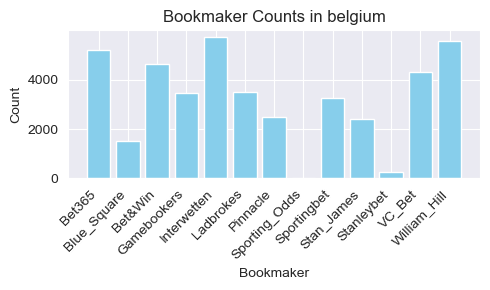

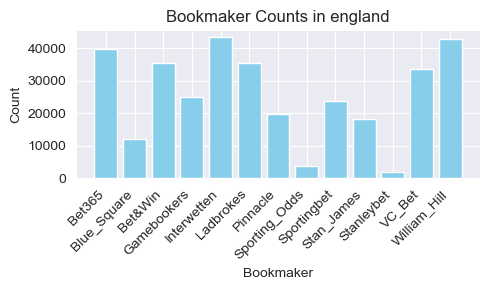

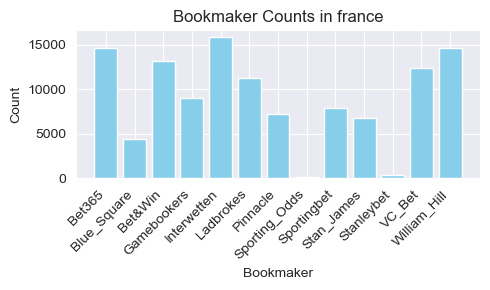

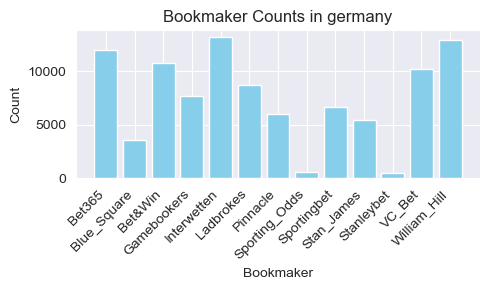

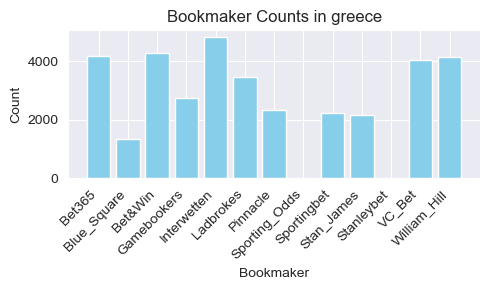

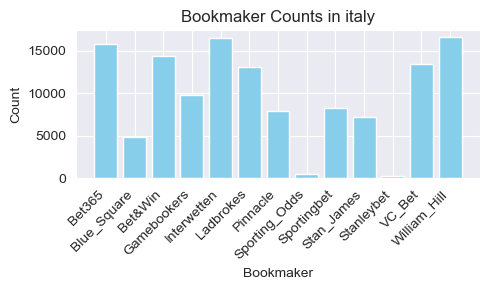

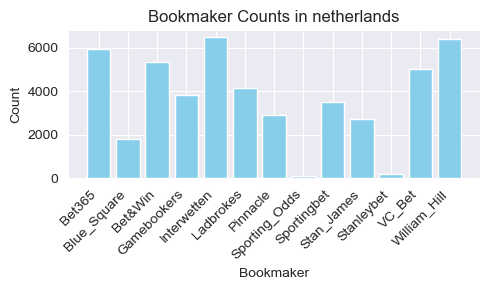

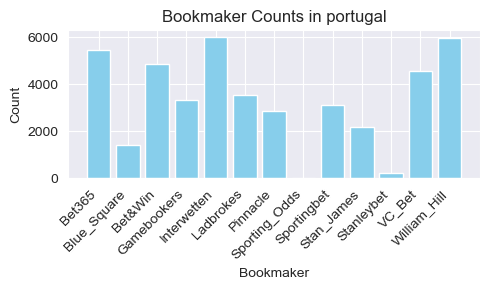

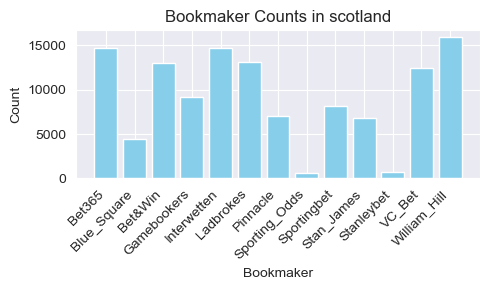

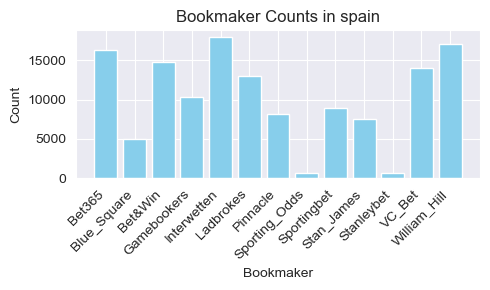

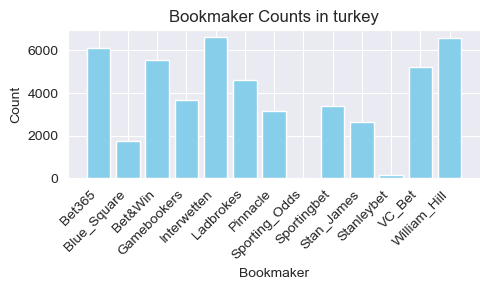

In [15]:
# Group by 'Country' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Country')[indicator_columns].sum().reset_index()

# Plot a bar chart for each country
for index, row in grouped_df.iterrows():
    country_name = row['Country']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {country_name}')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

### There is no significant difference in bet distribution between the bookmakers per country.

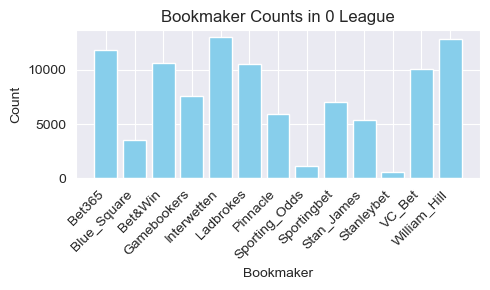

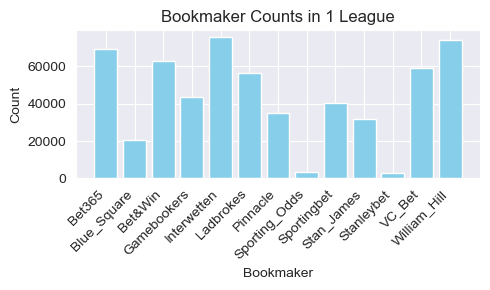

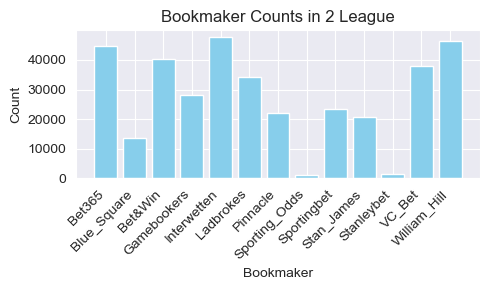

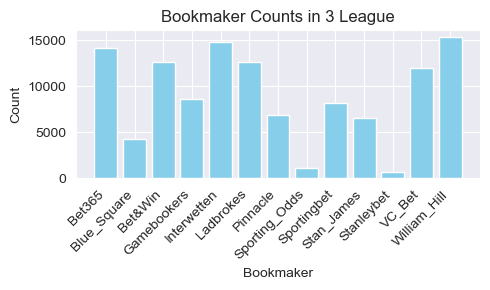

In [16]:
# Group by 'League' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('League')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['League']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} League')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

### There is no significant difference in bet distribution between the bookmakers per league.

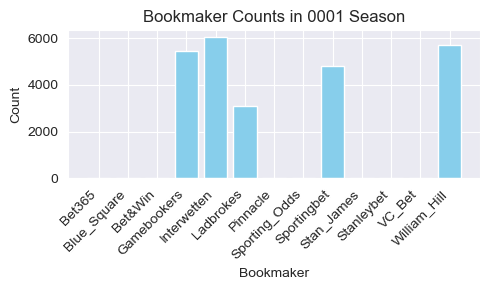

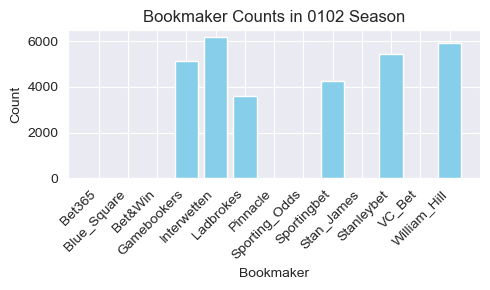

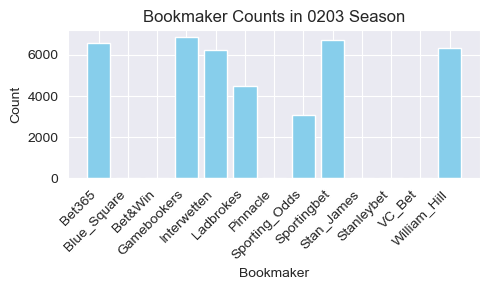

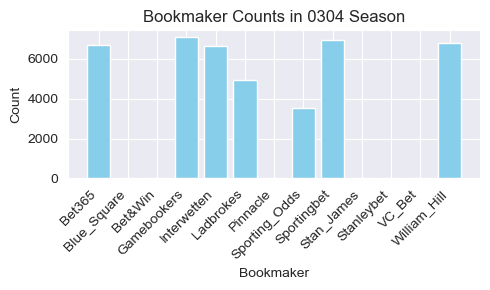

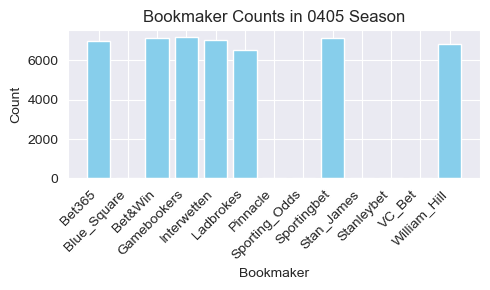

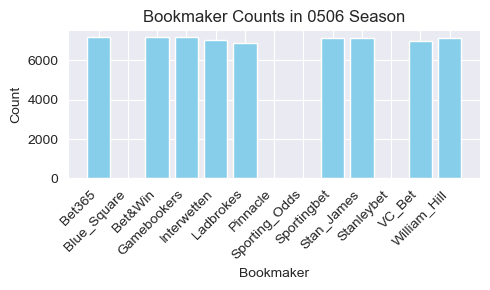

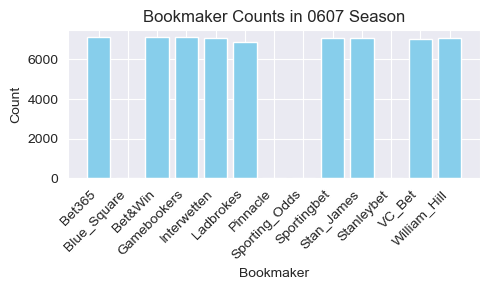

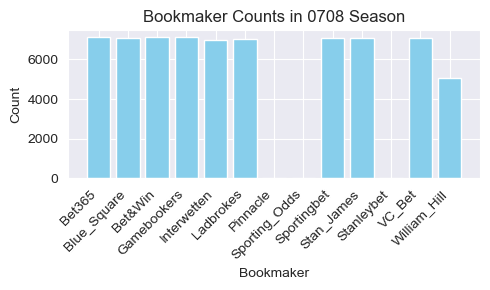

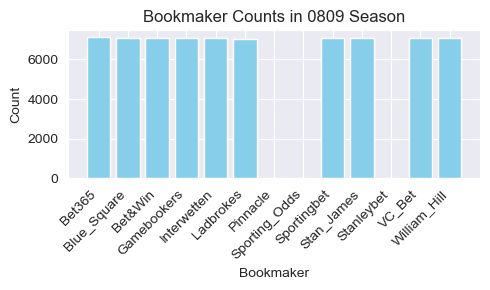

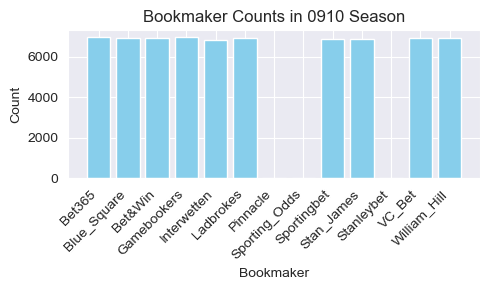

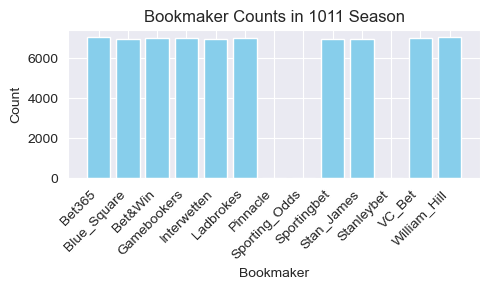

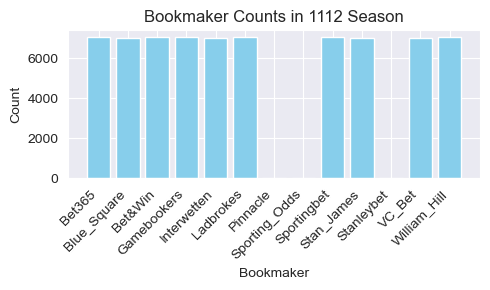

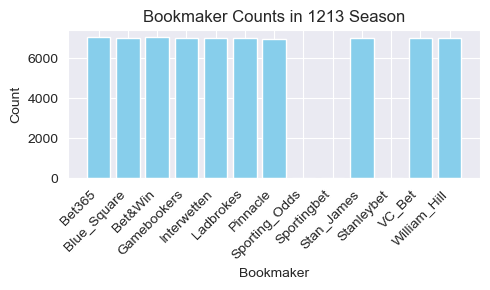

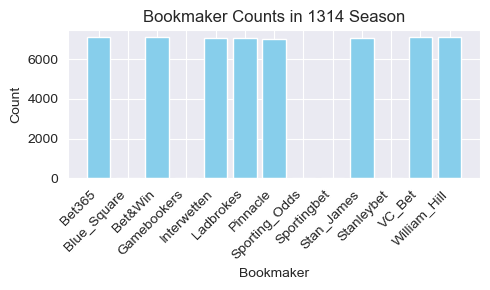

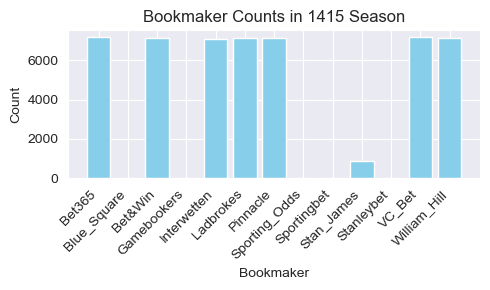

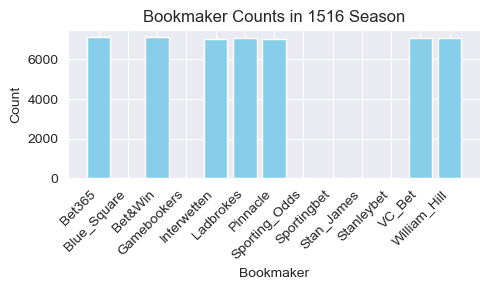

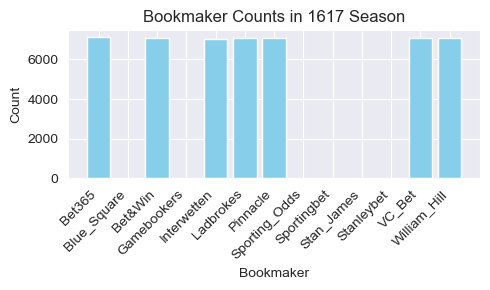

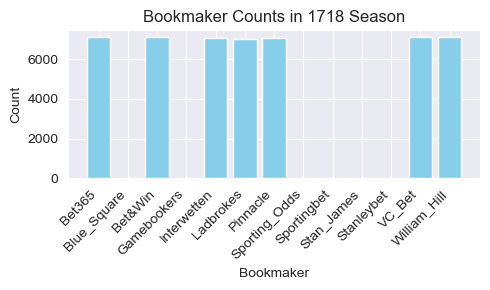

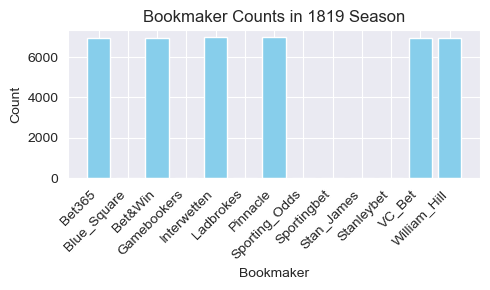

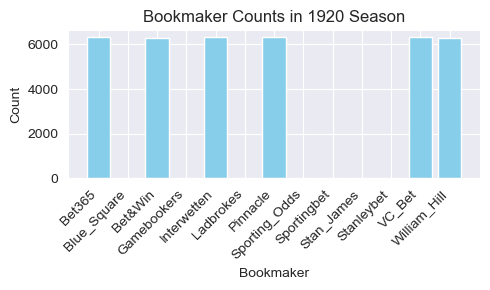

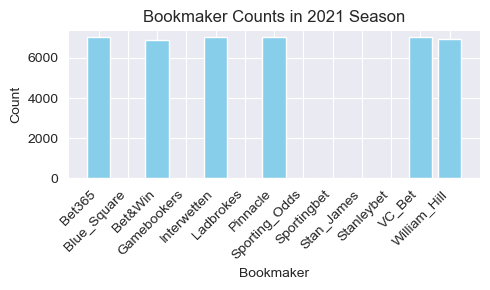

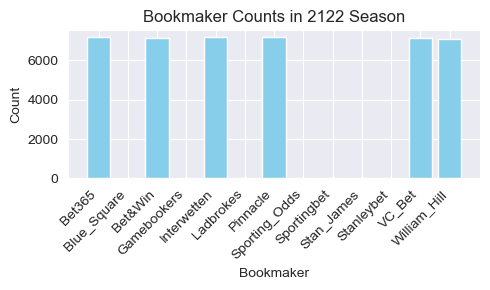

In [17]:
# Group by 'Season' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Season')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['Season']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} Season')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

## NAs treatment

In [18]:
train_df.describe()

,Full_Time_Home_Team_Goals,Full_Time_Away_Team_Goals,Half_Time_Home_Team_Goals,Half_Time_Away_Team_Goals,Gamebookers_home_win_odds,Gamebookers_draw_odds,Gamebookers_away_win_odds,Interwetten_home_win_odds,Interwetten_draw_odds,Interwetten_away_win_odds,...,Away_Team_Bookings_Points,Sporting_Odds_home_win_odds,Sporting_Odds_draw_odds,Sporting_Odds_away_win_odds,Ladbrokes_Asian_handicap_home_team_odds,Ladbrokes_Asian_handicap_away_team_odds,Ladbrokes_size_of_handicap_home_team,LB,LB.1,LB.2
count,154864.000000,154841.000000,154813.000000,154820.000000,88060.000000,88123.000000,88106.000000,150729.000000,150735.000000,150766.000000,...,6671.000000,6599.000000,6613.000000,6614.000000,5470.000000,5470.000000,5458.000000,110.000000,110.000000,107.000000
mean,2.216358,1.130883,0.655636,0.494206,2.275366,3.381363,3.950892,2.335784,3.382514,3.753866,...,20.914406,2.216488,3.391382,3.833776,1.911200,1.924793,-0.350500,1.985955,3.258182,3.808477
std,21.861876,1.108967,0.809382,0.708167,1.039952,0.613622,2.195107,1.155085,0.713629,2.251540,...,17.212936,0.983779,0.481409,2.078919,0.174042,0.124442,0.588259,0.434470,0.170338,1.309792
min,0.000000,-1.000000,0.000000,0.000000,1.030000,1.250000,1.030000,1.010000,1.500000,1.030000,...,0.000000,1.060000,2.380000,1.140000,-2.250000,-0.500000,-2.250000,1.360000,3.000000,1.900000
25%,1.000000,0.000000,0.000000,0.000000,1.730000,3.100000,2.650000,1.750000,3.050000,2.550000,...,10.000000,1.700000,3.200000,2.620000,1.840000,1.840000,-0.750000,1.684250,3.200000,2.800000
50%,1.000000,1.000000,0.000000,0.000000,2.100000,3.250000,3.350000,2.100000,3.200000,3.200000,...,20.000000,2.100000,3.250000,3.250000,1.920000,1.920000,-0.250000,1.909000,3.200000,3.500000
75%,2.000000,2.000000,1.000000,1.000000,2.450000,3.450000,4.500000,2.500000,3.450000,4.200000,...,30.000000,2.400000,3.400000,4.500000,2.000000,2.000000,0.000000,2.237500,3.250000,4.333000
max,998.000000,13.000000,7.000000,6.000000,24.000000,11.000000,34.000000,30.000000,16.000000,70.000000,...,150.000000,13.000000,8.000000,21.000000,3.400000,4.000000,9.000000,3.500000,4.000000,8.000000


In [19]:
train_df.isna().sum()

Country                                         0
League                                          0
Season                                          0
League_Division                               311
Match_Date                                    367
                                            ...  
Ladbrokes_Asian_handicap_away_team_odds    149703
Ladbrokes_size_of_handicap_home_team       149715
LB                                         155063
LB.1                                       155063
LB.2                                       155066
Length: 171, dtype: int64

Dropping rows with missing values of our target variable and main indicators as long as they have less than 1% missing data.

In [20]:
# Remove rows 
train_df = train_df.dropna(subset=['Full_Time_Result', 'Home_Team', 'Away_Team', 'Full_Time_Home_Team_Goals', 'Full_Time_Away_Team_Goals', 'Half_Time_Home_Team_Goals', 'Half_Time_Away_Team_Goals', 'Half_Time_Result'])

# check how many rows we have left after this operation
remaining_rows = train_df.shape[0]
print(remaining_rows)


154262


In [21]:
train_df_old = train_df.copy()

## Imputing missing match statistics values

In [22]:
# Identify the columns for match statistics
match_stats_columns = [
    'Home_Team_Shots', 'Away_Team_Shots', 
    'Home_Team_Shots_on_Target', 'Away_Team_Shots_on_Target', 
    'Home_Team_Corners', 'Away_Team_Corners', 
    'Home_Team_Yellow_Cards', 'Away_Team_Yellow_Cards',
    'Home_Team_Red_Cards', 'Away_Team_Red_Cards',
    'Home_Team_Fouls_Committed', 'Away_Team_Fouls_Committed',
    # Add any other relevant columns here
]
train_df[match_stats_columns].describe()

#for column in match_stats_columns:
    #plt.figure(figsize=(10, 4))
    #sns.histplot(train_df[column], kde=True)
    #plt.title(f'Distribution of {column}')
    #plt.show()'''

,Home_Team_Shots,Away_Team_Shots,Home_Team_Shots_on_Target,Away_Team_Shots_on_Target,Home_Team_Corners,Away_Team_Corners,Home_Team_Yellow_Cards,Away_Team_Yellow_Cards,Home_Team_Red_Cards,Away_Team_Red_Cards,Home_Team_Fouls_Committed,Away_Team_Fouls_Committed
count,91930.000000,91975.000000,91017.000000,91044.000000,91522.000000,91574.000000,92123.000000,92121.000000,92144.000000,92088.000000,89893.000000,89902.000000
mean,12.674502,10.296178,5.231232,4.208877,5.722559,4.647291,1.642663,1.960400,0.087103,0.119929,12.848442,13.340793
std,4.925064,4.383924,2.808099,2.456535,2.937115,2.623584,1.292940,1.365013,0.299639,0.351746,4.555581,4.628635
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,7.000000,3.000000,2.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000,10.000000,10.000000
50%,12.000000,10.000000,5.000000,4.000000,5.000000,4.000000,1.000000,2.000000,0.000000,0.000000,12.000000,13.000000
75%,16.000000,13.000000,7.000000,6.000000,7.000000,6.000000,2.000000,3.000000,0.000000,0.000000,16.000000,16.000000
max,46.000000,45.000000,27.000000,23.000000,26.000000,21.000000,11.000000,10.000000,3.000000,9.000000,145.000000,77.000000


### Checking if data is missing at random or not

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

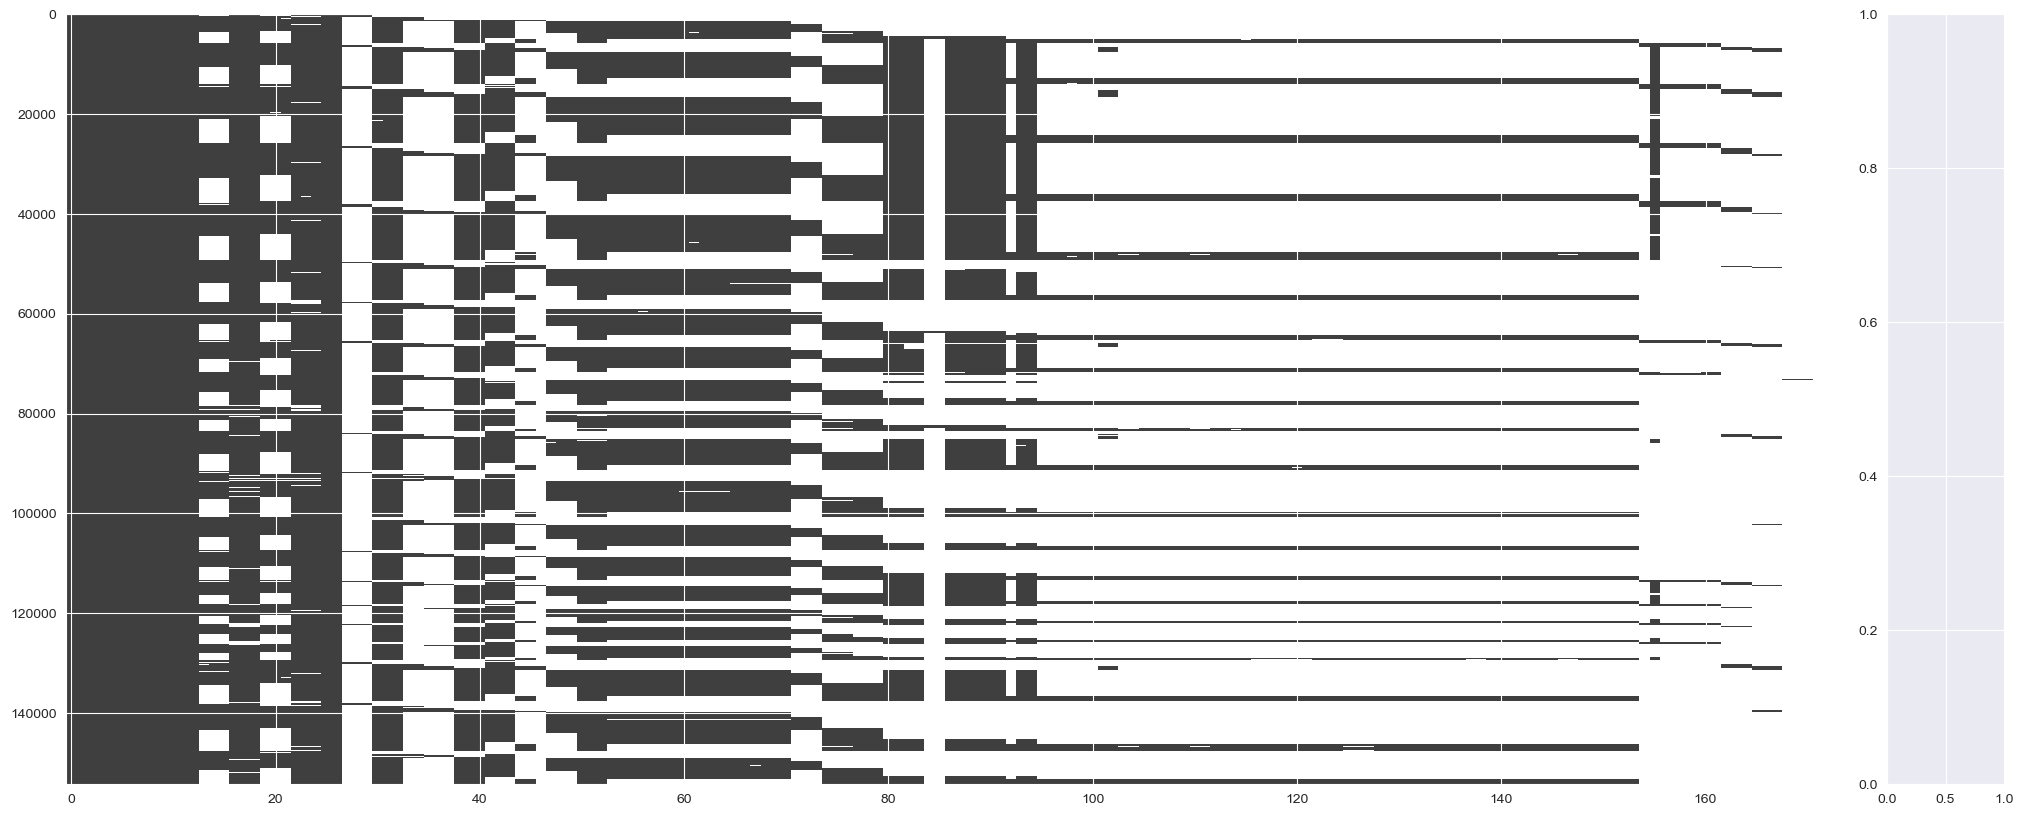

In [23]:
# Visualize the missingness pattern using missingno
msno.matrix(train_df)
plt.show()

msno.heatmap(train_df)
plt.show()

# Create a missingness indicator DataFrame
missing_indicator = train_df.isna()

# Heatmap of missingness correlation using standard correlation
sns.heatmap(missing_indicator.corr(), cmap='viridis', annot=True)
plt.title("Correlation Heatmap of Missing Data")
plt.show()

In [ ]:
# Complex Impputation

In [ ]:
# # Create a subset DataFrame with only the match statistics columns
# subset_df = train_df[match_stats_columns]
# 
# # Initialize the IterativeImputer
# iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
# 
# # Fit the imputer on your subset and transform it
# subset_df_imputed = iterative_imputer.fit_transform(subset_df)
# 
# # Create a DataFrame from the imputed subset data
# subset_df_imputed = pd.DataFrame(subset_df_imputed, columns=subset_df.columns)
# 
# # Check the result
# print(pd.DataFrame(subset_df_imputed, columns=match_stats_columns).isna().sum())

In [ ]:
# # Create a subset DataFrame with only the match statistics columns
# subset_df = train_df[match_stats_columns]
# 
# # Initialize the IterativeImputer with RandomForestRegressor as the estimator
# rf_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10), max_iter=10, random_state=0)
# 
# # Fit the imputer on your subset and transform it
# subset_df_imputed_rf = rf_imputer.fit_transform(subset_df)
# 
# # Create a DataFrame from the imputed subset data
# subset_df_imputed_rf = pd.DataFrame(subset_df_imputed_rf, columns=subset_df.columns)
# 
# # Check the result
# print(subset_df_imputed_rf.isna().sum())

In [ ]:
# Summary statistics for the original data
train_df_old[match_stats_columns].describe()

In [ ]:
# Summary statistics for the first imputation
# subset_df_imputed.describe()

In [ ]:
# Summary statistics for the RandomForest imputation
# subset_df_imputed_rf.describe()

In [ ]:
# Summary statistics for the original data
original_stats = train_df_old[match_stats_columns].describe()
# # Summary statistics for the first imputation
# first_impute_stats = subset_df_imputed.describe()
# # Summary statistics for the RandomForest imputation
# rf_impute_stats = subset_df_imputed_rf.describe()

In [ ]:
# Histograms for each variable
for column in match_stats_columns:
    plt.figure(figsize=(12, 6))
    plt.hist(train_df_old[column].dropna(), alpha=0.5, label='Original')
    plt.hist(subset_df_imputed[column], alpha=0.5, label='First Imputation')
    plt.hist(subset_df_imputed_rf[column], alpha=0.5, label='RF Imputation')
    plt.title(f'Distribution for {column}')
    plt.legend()
    plt.show()

In [ ]:
# Mean imputation
'''
mean_imputer = SimpleImputer(strategy='mean')
columns_for_mean_imputation = ['Home_Team_Shots', 'Away_Team_Shots', 
                               'Home_Team_Shots_on_Target', 'Away_Team_Shots_on_Target',
                               'Home_Team_Corners', 'Away_Team_Corners']

train_df[columns_for_mean_imputation] = mean_imputer.fit_transform(train_df[columns_for_mean_imputation])

# Median imputation
median_imputer = SimpleImputer(strategy='median')
columns_for_median_imputation = ['Home_Team_Yellow_Cards', 'Away_Team_Yellow_Cards',
                                 'Home_Team_Red_Cards', 'Away_Team_Red_Cards',
                                 'Home_Team_Fouls_Committed', 'Away_Team_Fouls_Committed']

train_df[columns_for_median_imputation] = median_imputer.fit_transform(train_df[columns_for_median_imputation])

# Check the result
print(train_df[match_stats_columns].isna().sum())'''

## Remove columns with excessive missingness

In [ ]:
'''# Define a threshold for the maximum allowed proportion of missing values
threshold = 0.98

# Calculate the proportion of missing values for each column
missing_proportion = train_df.isna().sum() / len(train_df)

# Identify columns that have missing values above the threshold
columns_to_drop = missing_proportion[missing_proportion > threshold].index.tolist()

# Drop these columns from the DataFrame
train_df = train_df.drop(columns=columns_to_drop)

# Display the columns that have been dropped
print(f"Columns dropped: {columns_to_drop}")'''


## Bookmakers odds corelation


In [ ]:

# Selecting home win odds from different bookmakers as an example
home_win_odds_columns = [
    "Bet365_home_win_odds", "Blue_Square_home_win_odds", "Bet&Win_home_win_odds",
    "Gamebookers_home_win_odds", "Interwetten_home_win_odds", "Ladbrokes_home_win_odds",
    "Pinnacle_home_win_odds", "Sporting_Odds_home_win_odds", "Sportingbet_home_win_odds",
    "Stan_James_home_win_odds", "Stanleybet_home_win_odds", "VC_Bet_home_win_odds",
    "William_Hill_home_win_odds"
]

# Compute the correlation matrix for home win odds
correlation_matrix_home_win = train_df[home_win_odds_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_home_win, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Home Win Odds')
plt.show()



In [ ]:
# Selecting draw odds from different bookmakers
draw_odds_columns = [
    "Bet365_draw_odds", "Blue_Square_draw_odds", "Bet&Win_draw_odds",
    "Gamebookers_draw_odds", "Interwetten_draw_odds", "Ladbrokes_draw_odds",
    "Pinnacle_draw_odds", "Sporting_Odds_draw_odds", "Sportingbet_draw_odds",
    "Stan_James_draw_odds", "Stanleybet_draw_odds", "VC_Bet_draw_odds",
    "William_Hill_draw_odds"
]

# Compute the correlation matrix for draw odds
correlation_matrix_draw = train_df[draw_odds_columns].corr()

# Generate a heatmap of the correlation matrix for draw odds
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_draw, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Draw Odds')
plt.show()
